# Time-Series Forecasting of COVID Cases in Canada

## Preprocessing 

We want to rename the column `date` to `ds` and our target column to `y` for the Prophet model.


In [1]:
import logging
import matplotlib.pyplot as plt
import pandas as pd
import prophet

RAW_DATA_PATH = "../data/covid19-download.csv"
PROVINCE_ID = "pruid"
PROVINCE_NAME = "prname"
PREDICTION_PERIODS = 30  # Prediction periods in days

# Set logging to ERROR
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.ERROR)


def _load_data(filepath: str) -> pd.DataFrame:
    """Loads data from a csv file.

    Args:
        filepath (str): filepath

    Returns:
    pd.DataFrame: dataframe
    """
    return pd.read_csv(filepath, parse_dates=["date"])


def _extract_province_id_name_as_dict(
    df: pd.DataFrame, province_id: str, province_name: str
) -> dict:
    """Extracts province id and name as a dictionary.

    Args:
        df (pd.DataFrame): dataframe

    Returns:
        dict: dictionary
    """
    return (
        df[[province_id, province_name]]
        .drop_duplicates()
        .set_index(province_id)
        .sort_index()
        .to_dict()[province_name]
    )


def _rename_columns(df: pd.DataFrame, name_map: dict) -> pd.DataFrame:
    """Renames columns.

    Args:
        df (pd.DataFrame): dataframe
        old_name (str): old name
        new_name (str): new name

    Returns:
        pd.DataFrame: dataframe
    """
    return df.rename(columns=name_map)


def _create_df_by_province(df: pd.DataFrame, provinces: dict) -> dict[pd.DataFrame]:
    """Creates a dictionary of dataframes by province.

    Args:
        df (pd.DataFrame): dataframe
        provinces (dict): provinces

    Returns:
        dict[pd.DataFrame]: dictionary of dataframes by province
    """
    output = {}
    for province_id in provinces.keys():
        output[province_id] = df[df[PROVINCE_ID] == province_id]
    return output


def generate_time_series_plots_by_province(province_dfs: dict[pd.DataFrame]) -> None:
    """Generate time series plots by province.

    Args:
        province_dfs (dict[pd.DataFrame]): dictionary of dataframes by province
    """
    _, ax = plt.subplots(
        nrows=len(province_dfs),
        ncols=1,
        figsize=(12, 40),
        constrained_layout=True,
    )

    for i, province_id in enumerate(province_dfs):
        province_df = province_dfs[province_id]
        province_model = _generate_model_for_province(province_df)
        province_forecast = _generate_forecast_for_province_model(
            province_model, PREDICTION_PERIODS
        )
        province_model.plot(province_forecast, ax=ax[i])
        ax[i].set_title(f"{province_df[PROVINCE_NAME].iloc[0]}")
        ax[i].set_ylabel("Number of Cases")
        ax[i].set_xlabel("Date")
        ax[i].grid(True)


def _generate_model_for_province(province_df: pd.DataFrame) -> prophet.Prophet:
    """Generates a model for a province.

    Args:
        province_df (pd.DataFrame): dataframe

    Returns:
        prophet.Prophet: model
    """
    model = prophet.Prophet()
    model.fit(province_df)
    return model


def _generate_forecast_for_province_model(
    province_model: prophet.Prophet, periods: int
) -> pd.DataFrame:
    """Generates a forecast for a province model.

    Args:
        province_model (prophet.Prophet): model
        periods (int): periods

    Returns:
        pd.DataFrame: dataframe
    """
    future = province_model.make_future_dataframe(periods=periods)
    return province_model.predict(future)

In [2]:
# Load data
df = _load_data(RAW_DATA_PATH)
df.head()

,pruid,prname,prnameFR,date,reporting_week,reporting_year,update,totalcases,numtotal_last7,ratecases_total,...,ratecases_last7,ratedeaths_last7,numtotal_last14,numdeaths_last14,ratetotal_last14,ratedeaths_last14,avgcases_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,59,British Columbia,Colombie-Britannique,2020-02-01,5,2020,1.0,1,1.0,0.02,...,0.02,0.0,NaN,NaN,NaN,NaN,0.18,0.0,0.0,0.0
1,48,Alberta,Alberta,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
2,47,Saskatchewan,Saskatchewan,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
3,46,Manitoba,Manitoba,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
4,35,Ontario,Ontario,2020-02-01,5,2020,1.0,3,3.0,0.02,...,0.02,0.0,NaN,NaN,NaN,NaN,0.43,0.0,0.0,0.0


In [3]:
# Extract province names
provinces = _extract_province_id_name_as_dict(df, PROVINCE_ID, PROVINCE_NAME)
provinces

{1: 'Canada',
 10: 'Newfoundland and Labrador',
 11: 'Prince Edward Island',
 12: 'Nova Scotia',
 13: 'New Brunswick',
 24: 'Quebec',
 35: 'Ontario',
 46: 'Manitoba',
 47: 'Saskatchewan',
 48: 'Alberta',
 59: 'British Columbia',
 60: 'Yukon',
 61: 'Northwest Territories',
 62: 'Nunavut',
 99: 'Repatriated travellers'}

In [4]:
# Rename columns
df = _rename_columns(df, {"date": "ds", "avgcases_last7": "y"})
df.head()

,pruid,prname,prnameFR,ds,reporting_week,reporting_year,update,totalcases,numtotal_last7,ratecases_total,...,ratecases_last7,ratedeaths_last7,numtotal_last14,numdeaths_last14,ratetotal_last14,ratedeaths_last14,y,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,59,British Columbia,Colombie-Britannique,2020-02-01,5,2020,1.0,1,1.0,0.02,...,0.02,0.0,NaN,NaN,NaN,NaN,0.18,0.0,0.0,0.0
1,48,Alberta,Alberta,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
2,47,Saskatchewan,Saskatchewan,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
3,46,Manitoba,Manitoba,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
4,35,Ontario,Ontario,2020-02-01,5,2020,1.0,3,3.0,0.02,...,0.02,0.0,NaN,NaN,NaN,NaN,0.43,0.0,0.0,0.0


## Prediction Modeling

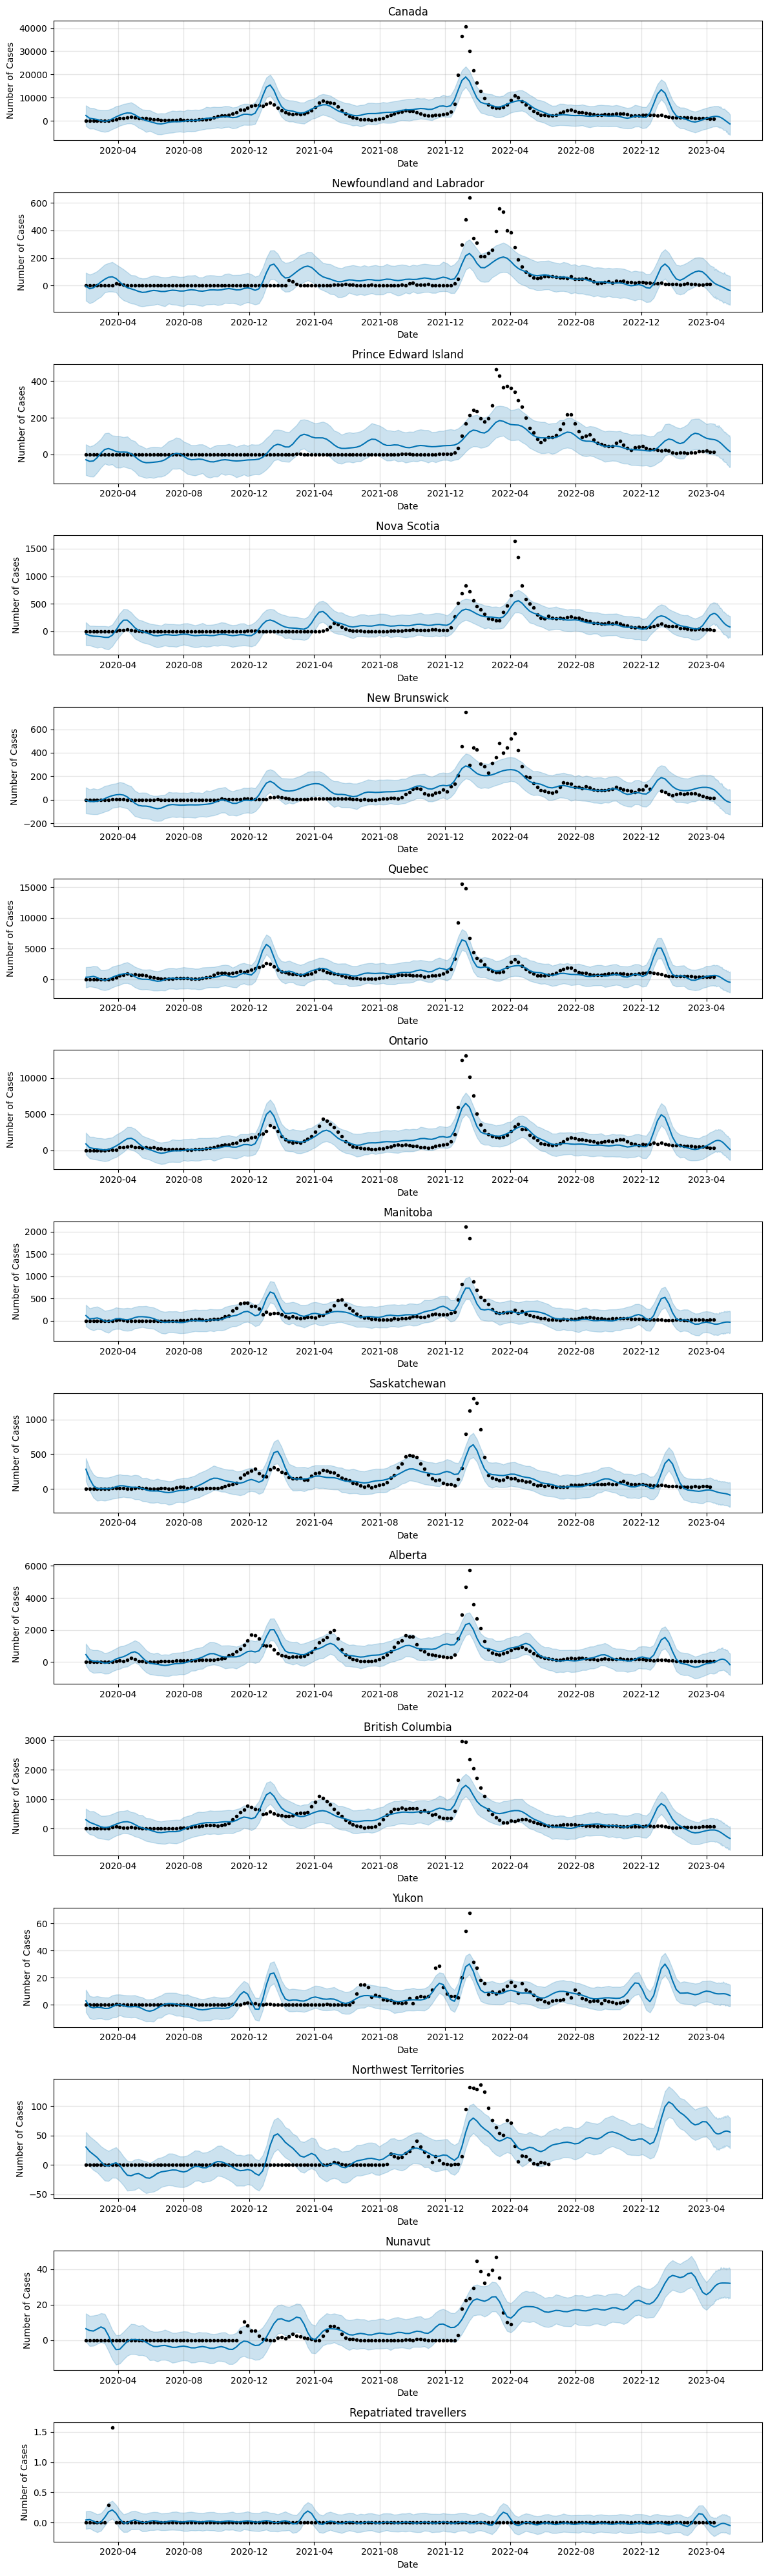

In [5]:
province_dfs = _create_df_by_province(df, provinces)
generate_time_series_plots_by_province(province_dfs)